In [1]:
import pandas as pd
import numpy as np

# トレインデータの読み込み
data_path = '/Users/hayakawakazue/Downloads/second_apt_2024_summer/train/train_41_42_43_44_45_46_47/train_41_42_43_44_45_46_47_clipped_outliers_transaction_date.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# データ型の確認
print("Data types of each column:\n", train_data.dtypes)

# 数値型の列を取得
numerical_cols = train_data.select_dtypes(include=['int64', 'float64']).columns
print("Numerical columns:\n", numerical_cols)

Data types of each column:
 市区町村コード           int64
最寄駅：距離（分）       float64
間取り              object
面積（㎡）             int64
建築年               int64
建物の構造            object
都市計画             object
建ぺい率（％）         float64
容積率（％）          float64
取引時点              int64
取引価格（総額）_log    float64
dtype: object
Numerical columns:
 Index(['市区町村コード', '最寄駅：距離（分）', '面積（㎡）', '建築年', '建ぺい率（％）', '容積率（％）', '取引時点',
       '取引価格（総額）_log'],
      dtype='object')


## 新しい特徴量を作成する

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

# トレインデータの読み込み
data_path = '/Users/hayakawakazue/Downloads/second_apt_2024_summer/train/train_41_42_43_44_45_46_47/train_41_42_43_44_45_46_47_clipped_outliers_transaction_date.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 取引時点から年を抽出
train_data['取引年'] = train_data['取引時点'].astype(str).str[:4].astype(int)

# 築年数を計算（取引年 - 建築年）
train_data['築年数'] = train_data['取引年'] - train_data['建築年']

# 取引月を抽出
train_data['取引月'] = train_data['取引時点'].apply(lambda x: int(str(x)[4:6]))

# 面積/築年数比を計算
train_data['面積/築年数比'] = train_data['面積（㎡）'] / train_data['築年数']

# 駅距離/面積の計算
train_data['駅距離_面積比'] = train_data['最寄駅：距離（分）'] / train_data['面積（㎡）']

# 容積率と建ぺい率の比率
train_data['容積率_建ぺい率比'] = train_data['容積率（％）'] / train_data['建ぺい率（％）']

# 面積と容積率の交互作用
train_data['面積×容積率'] = train_data['面積（㎡）'] * train_data['容積率（％）']

# 建築年と建ぺい率の交互作用
train_data['建築年×建ぺい率'] = train_data['建築年'] * train_data['建ぺい率（％）']

# 特徴量の確認
print(train_data[['取引年', '築年数', '取引月', '面積/築年数比', '駅距離_面積比', '容積率_建ぺい率比', '面積×容積率', '建築年×建ぺい率']].head())

# 新しい特徴量を含むデータを保存
output_path = '/Users/hayakawakazue/Downloads/second_apt_2024_summer/train/train_41_42_43_44_45_46_47/train_41_42_43_44_45_46_47_with_new_features1.csv'
train_data.to_csv(output_path, index=False)
print(f"新しい特徴量を含むデータを保存しました: {output_path}")


    取引年  築年数  取引月    面積/築年数比   駅距離_面積比  容積率_建ぺい率比   面積×容積率  建築年×建ぺい率
0  2022   31    6   2.258065  0.357143   3.333333  14000.0  119460.0
1  2022   23    6   3.260870  0.293333   2.500000  15000.0  159920.0
2  2010    9    3   8.333333  0.106667   3.333333  15000.0  120060.0
3  2019   28    6   2.321429  0.138462   3.333333  13000.0  119460.0
4  2009    1    6  75.000000  0.146667   5.000000  30000.0  160640.0
新しい特徴量を含むデータを保存しました: /Users/hayakawakazue/Downloads/second_apt_2024_summer/train/train_41_42_43_44_45_46_47/train_41_42_43_44_45_46_47_with_new_features1.csv


## 目的変数を使用して特徴量を作成する
データリーケージを防ぐためクロスバリデーションを用いて計算しています。

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold

# トレインデータの読み込み
data_path = '/Users/hayakawakazue/Downloads/second_apt_2024_summer/train/train_41_42_43_44_45_46_47/train_41_42_43_44_45_46_47_with_new_features1.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# クロスバリデーションの設定
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# エリア人気度スコア、長期価格トレンド、建築年スコアを格納するためのリスト
area_popularity_scores = np.zeros(len(train_data))
long_term_trend_scores = np.zeros(len(train_data))
year_built_scores = np.zeros(len(train_data))

for train_index, test_index in kf.split(train_data):
    X_train, X_test = train_data.iloc[train_index], train_data.iloc[test_index]
    
    # エリア人気度スコアの計算
    area_popularity = X_train.groupby('市区町村コード')['取引価格（総額）_log'].mean().reset_index()
    area_popularity.columns = ['市区町村コード', 'エリア人気度スコア']
    X_test = X_test.merge(area_popularity, on='市区町村コード', how='left')
    
    # 新しい長期価格トレンドの計算（面積と建築年を使用）
    X_train = X_train.copy()
    X_train['面積_建築年比'] = X_train['面積（㎡）'] / X_train['建築年']
    long_term_trend = X_train.groupby('面積_建築年比')['取引価格（総額）_log'].mean().reset_index()
    long_term_trend.columns = ['面積_建築年比', '長期価格トレンド']
    X_test['面積_建築年比'] = X_test['面積（㎡）'] / X_test['建築年']
    X_test = X_test.merge(long_term_trend, on='面積_建築年比', how='left')
    
    # 建築年スコアの計算
    train_data['建築年'] = train_data['建築年'].astype(int)
    year_built_score = X_train.groupby('建築年')['取引価格（総額）_log'].mean().reset_index()
    year_built_score.columns = ['建築年', '建築年スコア']
    X_test = X_test.merge(year_built_score, on='建築年', how='left')
    
    # スコアを格納
    area_popularity_scores[test_index] = X_test['エリア人気度スコア'].values
    long_term_trend_scores[test_index] = X_test['長期価格トレンド'].values
    year_built_scores[test_index] = X_test['建築年スコア'].values

# 結果をデータフレームに追加
train_data['エリア人気度スコア'] = area_popularity_scores
train_data['長期価格トレンド'] = long_term_trend_scores
train_data['建築年スコア'] = year_built_scores

# 特徴量の確認
print(train_data[['エリア人気度スコア', '長期価格トレンド', '建築年スコア']].head())

# 新しい特徴量を含むデータを保存
output_path = '/Users/hayakawakazue/Downloads/second_apt_2024_summer/train/train_41_42_43_44_45_46_47/train_41_42_43_44_45_46_47_with_new_features2.csv'
train_data.to_csv(output_path, index=False)
print(f"新しい特徴量を含むデータを保存しました: {output_path}")


   エリア人気度スコア  長期価格トレンド    建築年スコア
0   7.081338  7.170246  6.955915
1   7.226819  7.204755  7.225973
2   7.078185  7.273199  7.267552
3   7.145466  7.091737  6.955915
4   7.123625  7.348705  7.347707
新しい特徴量を含むデータを保存しました: /Users/hayakawakazue/Downloads/second_apt_2024_summer/train/train_41_42_43_44_45_46_47/train_41_42_43_44_45_46_47_with_new_features2.csv


## ワンポットエンコーディングを適用する

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import joblib

# トレインデータの読み込み
data_path = '/Users/hayakawakazue/Downloads/second_apt_2024_summer/train/train_41_42_43_44_45_46_47/train_41_42_43_44_45_46_47_with_new_features2.csv'

train_data = pd.read_csv(data_path, low_memory=False)

# ワンホットエンコーディングを適用するカテゴリ変数
categorical_columns = ['間取り', '建物の構造', '都市計画']

# OneHotEncoderのインスタンスを作成
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# カテゴリ変数をエンコード
encoded_columns = encoder.fit_transform(train_data[categorical_columns])

# エンコードされた列の名前を取得
encoded_col_names = encoder.get_feature_names_out(categorical_columns)

# エンコードされた列をデータフレームに変換
encoded_df = pd.DataFrame(encoded_columns, columns=encoded_col_names)

# オリジナルのデータフレームにエンコードされた列を追加
train_data = train_data.drop(categorical_columns, axis=1)
train_data = pd.concat([train_data, encoded_df], axis=1)

# 特徴量の確認
print(train_data.head())

# 新しい特徴量を含むデータを保存
output_path = '/Users/hayakawakazue/Downloads/second_apt_2024_summer/train/train_41_42_43_44_45_46_47/train_41_42_43_44_45_46_47_with_onehot_encoded_features.csv'
train_data.to_csv(output_path, index=False)
print(f"新しい特徴量を含むデータを保存しました: {output_path}")

# エンコーダーを保存
encoder_path = '/Users/hayakawakazue/Downloads/second_apt_2024_summer/train/train_41_42_43_44_45_46_47/onehot_encoder.pkl'
joblib.dump(encoder, encoder_path)
print(f"エンコーダーを保存しました: {encoder_path}")


   市区町村コード  最寄駅：距離（分）  面積（㎡）   建築年  建ぺい率（％）  容積率（％）    取引時点  取引価格（総額）_log  \
0    41201       25.0     70  1991     60.0   200.0  202206      7.342423   
1    41203       22.0     75  1999     80.0   200.0  202206      7.079181   
2    41201        8.0     75  2001     60.0   200.0  201003      7.255273   
3    41202        9.0     65  1991     60.0   200.0  201906      7.113943   
4    41202       11.0     75  2008     80.0   400.0  200906      7.146128   

    取引年  築年数  ...  都市計画_調整区域  都市計画_近隣商業  都市計画_都計外  都市計画_非線引き  都市計画_１中住専  \
0  2022   31  ...        0.0        0.0       0.0        0.0        0.0   
1  2022   23  ...        0.0        0.0       0.0        0.0        0.0   
2  2010    9  ...        0.0        0.0       0.0        0.0        0.0   
3  2019   28  ...        0.0        0.0       0.0        0.0        0.0   
4  2009    1  ...        0.0        0.0       0.0        0.0        0.0   

   都市計画_１低住専  都市計画_１種住居  都市計画_２中住専  都市計画_２低住専  都市計画_２種住居  
0        0.0        0.0    

## カラム名のリストを表示する

In [6]:
import pandas as pd
import numpy as np

# トレインデータの読み込み
data_path = '/Users/hayakawakazue/Downloads/second_apt_2024_summer/train/train_41_42_43_44_45_46_47/train_41_42_43_44_45_46_47_with_onehot_encoded_features.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# カラム名のリストを表示
print(train_data.columns.tolist())


['市区町村コード', '最寄駅：距離（分）', '面積（㎡）', '建築年', '建ぺい率（％）', '容積率（％）', '取引時点', '取引価格（総額）_log', '取引年', '築年数', '取引月', '面積/築年数比', '駅距離_面積比', '容積率_建ぺい率比', '面積×容積率', '建築年×建ぺい率', 'エリア人気度スコア', '長期価格トレンド', '建築年スコア', '間取り_オープンフロア', '間取り_１ＤＫ', '間取り_１Ｋ', '間取り_１Ｋ＋Ｓ', '間取り_１ＬＤＫ', '間取り_１ＬＤＫ＋Ｓ', '間取り_１ＬＫ', '間取り_１Ｒ', '間取り_２ＤＫ', '間取り_２ＤＫ＋Ｓ', '間取り_２Ｋ', '間取り_２ＬＤＫ', '間取り_２ＬＤＫ＋Ｓ', '間取り_３ＤＫ', '間取り_３ＤＫ＋Ｓ', '間取り_３Ｋ', '間取り_３ＬＤＫ', '間取り_３ＬＤＫ＋Ｓ', '間取り_３ＬＫ', '間取り_３ＬＫ＋Ｓ', '間取り_４ＤＫ', '間取り_４Ｋ', '間取り_４ＬＤＫ', '間取り_４ＬＤＫ＋Ｓ', '間取り_５ＤＫ', '間取り_５Ｋ', '間取り_５ＬＤＫ', '間取り_６ＬＤＫ', '間取り_７ＤＫ', '建物の構造_木造', '建物の構造_鉄骨造', '建物の構造_ＲＣ', '建物の構造_ＲＣ、ブロック造', '建物の構造_ＲＣ、鉄骨造', '建物の構造_ＳＲＣ', '都市計画_商業', '都市計画_工業', '都市計画_工業専用', '都市計画_準住居', '都市計画_準工業', '都市計画_調整区域', '都市計画_近隣商業', '都市計画_都計外', '都市計画_非線引き', '都市計画_１中住専', '都市計画_１低住専', '都市計画_１種住居', '都市計画_２中住専', '都市計画_２低住専', '都市計画_２種住居']


## スケーリングを適用する

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib

# トレインデータの読み込み
data_path = '/Users/hayakawakazue/Downloads/second_apt_2024_summer/train/train_41_42_43_44_45_46_47/train_41_42_43_44_45_46_47_with_onehot_encoded_features.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# スケーリングを適用する数値変数のリスト
numeric_columns = [
    '市区町村コード', '最寄駅：距離（分）', '面積（㎡）', '建築年', '建ぺい率（％）', '容積率（％）', 
    '取引時点', '取引年', '築年数', '取引月', '面積/築年数比', '駅距離_面積比', 
    '容積率_建ぺい率比', '面積×容積率', '建築年×建ぺい率', 'エリア人気度スコア', 
    '長期価格トレンド', '建築年スコア'
]

# 無限大や非常に大きな値を検出し、適切に処理する関数
def replace_infinite_and_large_values(df, columns):
    for col in columns:
        df[col] = df[col].replace([np.inf, -np.inf], np.nan)  # 無限大をNaNに置換
        max_val = df[col][~np.isnan(df[col])].max()  # NaNを除く最大値を取得
        df[col] = np.where(df[col] > max_val, max_val, df[col])  # 非常に大きな値を最大値に置換
    return df

# 無限大や非常に大きな値を処理
train_data = replace_infinite_and_large_values(train_data, numeric_columns)

# NaN値を適切に処理（例：列の平均値で補完）
train_data[numeric_columns] = train_data[numeric_columns].fillna(train_data[numeric_columns].mean())

# StandardScalerのインスタンスを作成
scaler = StandardScaler()

# 数値変数をスケーリング
train_data[numeric_columns] = scaler.fit_transform(train_data[numeric_columns])

# 特徴量の確認
print(train_data.head())

# 新しい特徴量を含むデータを保存
output_path = '/Users/hayakawakazue/Downloads/second_apt_2024_summer/train/train_41_42_43_44_45_46_47/train_41_42_43_44_45_46_47_scaled_features.csv'
train_data.to_csv(output_path, index=False)
print(f"新しい特徴量を含むデータを保存しました: {output_path}")

# スケーラーを保存
scaler_path = '/Users/hayakawakazue/Downloads/second_apt_2024_summer/train/train_41_42_43_44_45_46_47/scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"スケーラーを保存しました: {scaler_path}")


    市区町村コード  最寄駅：距離（分）     面積（㎡）       建築年   建ぺい率（％）    容積率（％）      取引時点  \
0 -1.751202   0.109433  0.096706 -0.577319 -1.275628 -0.615386  1.198507   
1 -1.750106  -0.063361  0.363212  0.240652  0.754292 -0.615386  1.198507   
2 -1.751202  -0.869733  0.363212  0.445145 -1.275628 -0.615386 -1.247432   
3 -1.750654  -0.812135 -0.169800 -0.577319 -1.275628 -0.615386  0.588547   
4 -1.750654  -0.696939  0.363212  1.160870  0.754292  1.254203 -1.444653   

   取引価格（総額）_log       取引年       築年数  ...  都市計画_調整区域  都市計画_近隣商業  都市計画_都計外  \
0      7.342423  1.200524  1.131585  ...        0.0        0.0       0.0   
1      7.079181  1.200524  0.348161  ...        0.0        0.0       0.0   
2      7.255273 -1.237529 -1.022830  ...        0.0        0.0       0.0   
3      7.113943  0.591011  0.837801  ...        0.0        0.0       0.0   
4      7.146128 -1.440700 -1.806254  ...        0.0        0.0       0.0   

   都市計画_非線引き  都市計画_１中住専  都市計画_１低住専  都市計画_１種住居  都市計画_２中住専  都市計画_２低住専  都市計画_２種住居  
0    

## モデルが重要とする特徴量を可視化する

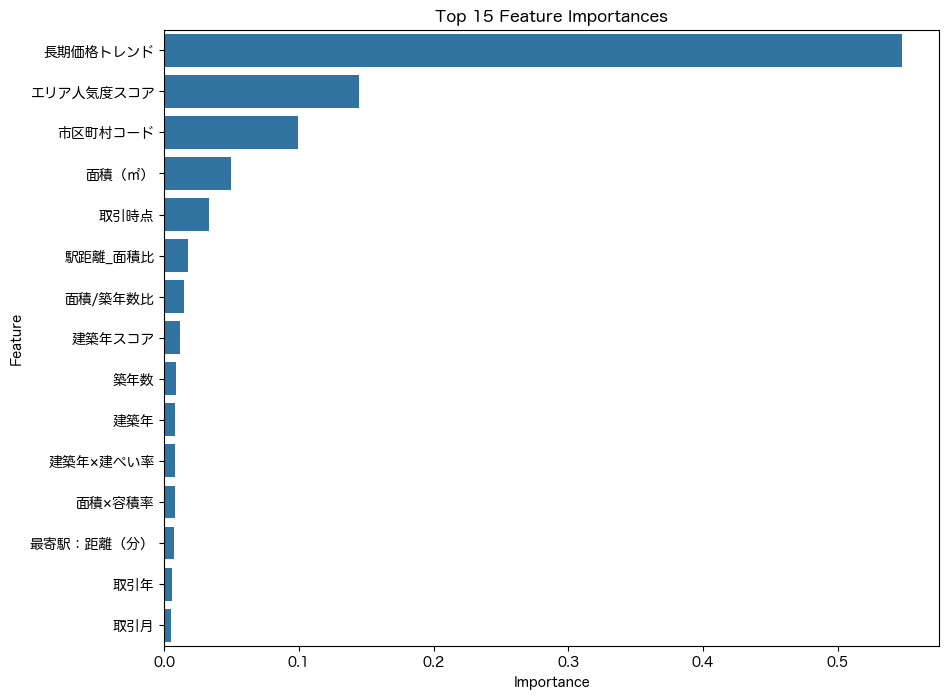

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# 日本語フォントの設定
plt.rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro']  # Mac用
plt.rcParams['axes.unicode_minus'] = False

# トレインデータの読み込み
data_path = '/Users/hayakawakazue/Downloads/second_apt_2024_summer/train/train_13_27/train_13_27_scaled_features.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量とターゲットの分割
X = train_data.drop(columns=['取引価格（総額）_log'])
y = train_data['取引価格（総額）_log']

# 無限大または非常に大きな値を処理
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# 欠損値を持つ行を削除（特徴量とターゲットの両方）
non_na_indices = X.dropna().index
X = X.loc[non_na_indices]
y = y.loc[non_na_indices]

# ランダムフォレスト回帰モデルのインスタンスを作成
model = RandomForestRegressor(random_state=24)

# モデルのトレーニング
model.fit(X, y)

# 特徴量重要度の取得
feature_importances = model.feature_importances_
feature_names = X.columns

# データフレームに変換
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})

# 重要度の降順に並べ替え
importance_df = importance_df.sort_values('importance', ascending=False)

# 上位15の特徴量を取得
top_15_features = importance_df.head(15)

# 可視化
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=top_15_features)
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


## 残差分析とQQプロットモデルの評価

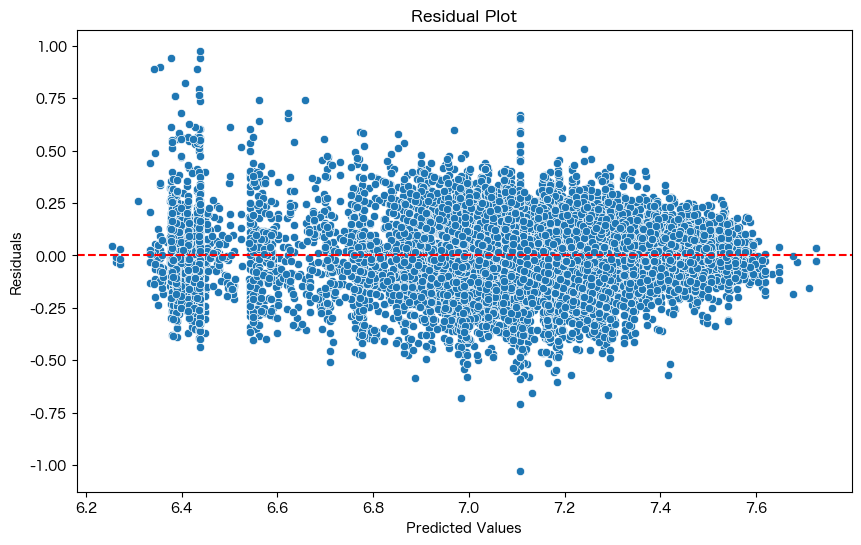

MSE: 0.02361995245882015


In [9]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

# 保存されたデータの読み込み
df = pd.read_csv('/Users/hayakawakazue/Downloads/second_apt_2024_summer/train/train_41_42_43_44_45_46_47/train_41_42_43_44_45_46_47_scaled_features.csv')

# 線形回帰モデルの設定とフィッティング
model = LinearRegression()
X = df[['長期価格トレンド']]  # 説明変数
y = df['取引価格（総額）_log'] # 応答変数
model.fit(X, y)

# 予測と残差の計算
predictions = model.predict(X)
residuals = y - predictions

# 残差プロット
plt.figure(figsize=(10, 6))
sns.scatterplot(x=predictions, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# 残差の評価（MSEの計算）
mse = mean_squared_error(y, predictions)
print(f'MSE: {mse}')
